In [1]:
import pandas as pd
import matplotlib as mp

%matplotlib inline

In [2]:
auctions = pd.read_csv('../data/auctions.csv.gzip',compression='gzip',\
                        usecols=['date','device_id','platform','ref_type_id','source_id'],\
                        dtype={'device_id':'int64','platform':'category','ref_type_id':'category','source_id':'category'},\
                        parse_dates=['date'])

## Cada 3 dias, cuantas veces aparece un mismo id en promedio?

In [3]:
auctions.head()

,date,device_id,platform,ref_type_id,source_id
0,2019-03-11 14:18:33.290763,6059599345986491085,1,1,0
1,2019-03-11 14:18:34.440157,1115994996230693426,1,1,0
2,2019-03-11 14:18:35.862360,7463856250762200923,1,1,0
3,2019-03-11 14:18:36.167163,7829815350267792040,1,1,0
4,2019-03-11 14:18:37.728590,1448534231953777480,1,1,0


Primero se busca cuanto es el promedio de veces que aparece un usuario en las subastas. 

Se usan grupos de 3 dias para segmentar los datos ya que es la ventana que toma Jaamp.


In [4]:
#Divido el intervalo en segmentos de 3 dias consecutivos que analizo por separado
auctions['date_frame'] = (auctions['date'].dt.day - auctions['date'].dt.day.min()) % 3
grp = ['device_id', 'date_frame']
#Ordeno por grp y fecha
auctions.sort_values(by=['device_id', 'date_frame', 'date'], inplace=True)

('Prom. de apariciones de usuarios en 3 dias: ', 43.157112615493176)
('Min. de apariciones de usuarios en 3 dias: ', 1)
('Max. de apariciones de usuarios en 3 dias: ', 11910)
('Med. de apariciones de usuarios en 3 dias: ', 9.0)
('Total de Registros: ', 453490)


Text(0,0.5,'Cant. Usuarios')

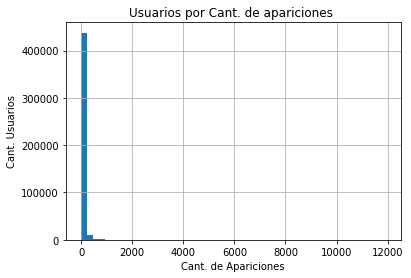

In [5]:
app_dev_id = auctions.groupby(grp, sort=False)['date'].count()
print('Prom. de apariciones de usuarios en 3 dias: ', app_dev_id.mean())
print('Min. de apariciones de usuarios en 3 dias: ', app_dev_id.min())
print('Max. de apariciones de usuarios en 3 dias: ', app_dev_id.max())
print('Med. de apariciones de usuarios en 3 dias: ', app_dev_id.median())
print('Total de Registros: ', app_dev_id.count())

plot = app_dev_id.hist(bins=50)
plot.set_title("Usuarios por Cant. de apariciones ")
plot.set_xlabel("Cant. de Apariciones")
plot.set_ylabel("Cant. Usuarios")

Elimino los que aparecen una sola vez (no se puede estimar tiempo de arribo) y los que aparecen mas de 100 veces (No tiene sentido, estan muy por arriba de la mediana)

('Prom. de apariciones de usuarios en 3 dias: ', 27.35093602995296)
('Min. de apariciones de usuarios en 3 dias: ', 3)
('Max. de apariciones de usuarios en 3 dias: ', 149)
('Med. de apariciones de usuarios en 3 dias: ', 14.0)
('Total de Registros: ', 312490)


Text(0,0.5,'Cant. Usuarios')

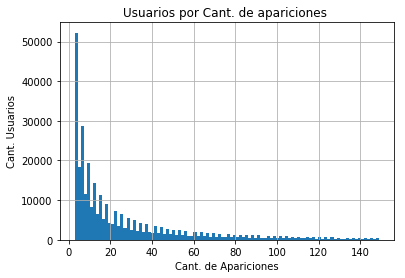

In [6]:
min_value = 2
max_value = 150

#Entre 1 y 1000 quedan 381582 registros 
#Entre 1 y 300 quedan 371666 registros
#Entre 5 y 200 quedan 250549 registros

auctions = auctions.groupby(grp, sort=False).filter(lambda data: (min_value < len(data) < max_value))
                                                                                                                  
app_dev_id = auctions.groupby(grp, sort=False)['date'].count()
print('Prom. de apariciones de usuarios en 3 dias: ', app_dev_id.mean())
print('Min. de apariciones de usuarios en 3 dias: ', app_dev_id.min())
print('Max. de apariciones de usuarios en 3 dias: ', app_dev_id.max())
print('Med. de apariciones de usuarios en 3 dias: ', app_dev_id.median())
print('Total de Registros: ', app_dev_id.count())

plot = app_dev_id.hist(bins=100)
plot.set_title("Usuarios por Cant. de apariciones ")
plot.set_xlabel("Cant. de Apariciones")
plot.set_ylabel("Cant. Usuarios")

In [7]:
app_dev_id.describe()

count    312490.000000
mean         27.350936
std          31.332911
min           3.000000
25%           6.000000
50%          14.000000
75%          36.000000
max         149.000000
Name: date, dtype: float64

## Cada 3 dias, cuanto es el tiempo promedio entre apariciones de un dispositivo? 

In [11]:
auctions['next_date'] = auctions.groupby(grp, as_index = False, sort=False)['date']\
                                              .transform(lambda x: x.shift(-1))
auctions = auctions.loc[(~auctions['next_date'].isnull())]
auctions['secs_to_next'] = (auctions['next_date'] - auctions['date'])\
                                        .transform(lambda x: round(x.total_seconds(), 2))

/home/gatti2602/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
auctions.head()

,date,device_id,platform,ref_type_id,source_id,date_frame,next_date,secs_to_next
16055271,2019-03-08 11:20:19.361762,113858820194433,1,1,0,0,2019-03-08 11:20:19.411501,0.05
7910618,2019-03-08 11:20:19.411501,113858820194433,1,1,0,0,2019-03-08 13:41:53.701108,8494.29
10114916,2019-03-08 13:41:53.701108,113858820194433,1,1,0,0,2019-03-11 00:47:34.259903,212740.56
10198607,2019-03-11 00:47:34.259903,113858820194433,1,1,0,0,2019-03-11 22:05:35.290441,76681.03
17311907,2019-03-11 22:05:35.290441,113858820194433,1,1,0,0,2019-03-11 23:43:52.418474,5897.13


In [13]:
auctions.groupby('date_frame')['secs_to_next'].describe()

,count,mean,std,min,25%,50%,75%,max
date_frame,,,,,,,,
0,2620914.0,11109.700431,49839.340738,0.0,5.36,45.74,402.390,601189.10
1,2621983.0,11079.701738,51230.262371,0.0,4.89,42.09,366.000,602045.94
2,2991507.0,11693.655876,51991.247801,0.0,5.29,44.93,448.025,603942.98


Se observa que el 3 cuantil se encuentra por abajo de los 150 seg siempre, lo que indica que la mayoria de las veces un dispositivo aparece varias veces en un tiempo muy acotado y luego desaparece por bastante tiempo hasta que aparece de nuevo.

Se filtran los que tardaron mas de 120 seg. para que no se vean una cantidad grande de outliers en el boxplot

In [15]:
filtered = auctions.loc[auctions['secs_to_next'] < 120]

In [16]:
filtered.groupby('date_frame')['secs_to_next'].describe()

,count,mean,std,min,25%,50%,75%,max
date_frame,,,,,,,,
0,1651685.0,24.456697,29.775551,0.0,2.01,10.43,37.48,119.99
1,1675170.0,23.908661,29.508505,0.0,1.93,9.88,36.53,119.99
2,1877120.0,23.897391,29.373083,0.0,1.96,10.11,36.27,119.99


In [17]:
#Quiero estandarizar los datos y ver si la distribucion es similar en los grupos de 3 dias
#filtered.groupby('date_frame')['secs_to_next'].transform(lambda x: ((x-x.mean()) / x.std())) 

Text(0,0.5,'Tiempo (Seg.)')

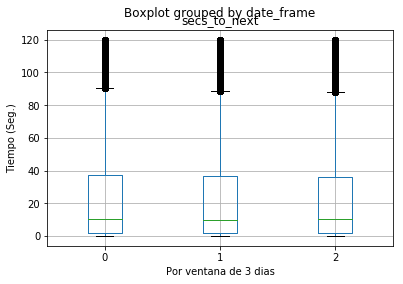

In [23]:
plot = filtered.boxplot(by='date_frame', column='secs_to_next')
#plot.set_title("Tiempo entre apariciones")
plot.set_xlabel("Por ventana de 3 dias")
plot.set_ylabel("Tiempo (Seg.)")

Se observa que para los 3 periodos se mantiene la tendencia a que los usuarios aparezcan varias veces en rafagas de periodos muy cortos. Desapareciendo luego por un periodo mas extenso. 

Es asi que podria decirse que si un usuario aparecio hace poco tiene mas probabilidades de volver a aparecer que un usuario que aparecio hace mas tiempo (Probablemente ya no esta usando la aplicacion).

Text(0,0.5,'Proporcion de los casos')

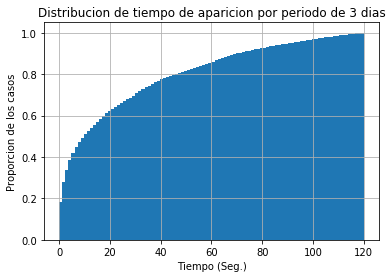

In [25]:
plt = filtered['secs_to_next'].hist(bins = 100, density=True, cumulative=True)
plt.set_title("Distribucion de tiempo de aparicion por periodo de 3 dias")
plt.set_xlabel("Tiempo (Seg.)")
plt.set_ylabel("Proporcion de los casos")

## En que horarios hay mas subastas? Dia Laboral vs Dia no Laboral

In [26]:
auctions['hour'] = auctions['date'].dt.hour
auctions['is_weekend'] = auctions['date'].dt.weekday >= 5

Text(0,0.5,u'Cant. de encuestas')

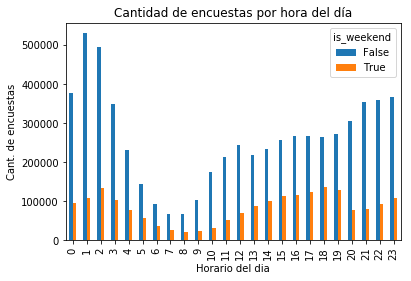

In [34]:
plot = auctions.groupby('is_weekend')['hour'].value_counts().unstack().transpose().plot.bar()
plot.set_title(u'Cantidad de encuestas por hora del día')
plot.set_xlabel(u'Horario del dia')
plot.set_ylabel(u'Cant. de encuestas')

Text(0,0.5,u'Cant. de encuestas')

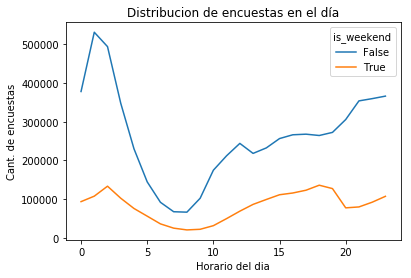

In [35]:
plot = auctions.groupby('is_weekend')['hour'].value_counts().unstack().transpose().plot()
plot.set_title(u'Distribucion de encuestas en el día')
plot.set_xlabel(u'Horario del dia')
plot.set_ylabel(u'Cant. de encuestas')